# Project - Colon Tumor Classification (256x256)-Pretrained

Lab Group 8:

- Gnana Spandana Akumalla
- Patrik Svensson
- Serkan Arda Yilal

In this file, we are doing hyperparameter tuning on selected number of colon images with tumor and non-tumor labels. We use an image size of 256x256 and use a pretrained VGG16 model to extract features and train them on MLP model.

In [1]:
import os 
import time
import gc
import pickle
from datetime import datetime
from timeit import default_timer as timer
import random
random.seed(0)

from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout
import tensorflow as tf 
tf.random.set_seed(0)
import keras
from statistics import mean as mean_calc

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy

import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from Utils_project import load_data, hyperparameter_tuner, pretrained_hyperparameter_tuner, distribution_check, train_val_folds

from Models import vgg16_model, MLP_model
from tensorflow.keras import applications
import psutil






Checking GPU availability

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4777168441132189458
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10908663808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17048854625008950568
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

We first, set the paths for saving trained models, training histories, and training result reports.

In [4]:
current_dir =os.getcwd()


best_models_path = os.path.join(current_dir, "best_models")
model_histories_path = os.path.join(current_dir, "model_histories")
training_results_path = os.path.join(current_dir, "training_results")

paths = [best_models_path, model_histories_path, training_results_path]

if not os.path.exists(best_models_path):
    os.mkdir(best_models_path)
    print("best models directory is created " + best_models_path)
    
if not os.path.exists(model_histories_path):
    os.mkdir(model_histories_path)
    print("model histories directory is created " + model_histories_path)
    
if not os.path.exists(training_results_path):
    os.mkdir(training_results_path)
    print("training results directory is created " + training_results_path)



Defining data directory for tumor and non-tumor images along with their sizes

In [5]:
# Defining paths
data_dir = 'project_dataset/colon_images/'
NT_dir = os.path.join(data_dir, 'non-tumor/') # nT=non-Tumor
T_dir = os.path.join(data_dir, 'tumor/') # T=Tumor

# Defining constants
img_height=256
img_width=256


In [6]:
print("Total number of non-tumor images:",len(os.listdir(NT_dir)))
print("Total number of tumor images:",len(os.listdir(T_dir)))



Total number of non-tumor images: 6494
Total number of tumor images: 3515


## Data loading and pre-processing

Loading images. Due to memory problems, we had to choose 750 images per class. Also, considering pretrained models require 3 channel images, we chose colored images, which used more memory to store.

In [7]:
# Loads images 
t0=time.time()

NT_imgs = load_data(NT_dir, img_height, img_width, number_of_images = 750, color = True)

print("Loading", len(NT_imgs)," non-tumor images took", round(time.time()-t0), "seconds")

t1=time.time()

T_imgs = load_data(T_dir, img_height, img_width, number_of_images = 750, color = True)

print("Loading", len(T_imgs)," tumor images took", round(time.time()-t1), "seconds")



Loading 750  non-tumor images took 36 seconds
Loading 750  tumor images took 35 seconds


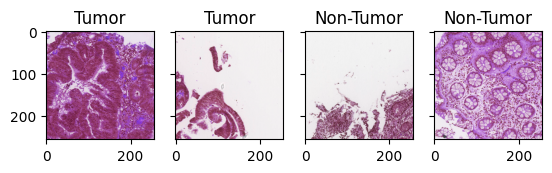

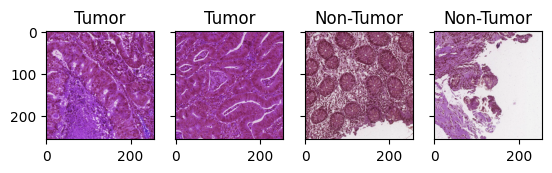

In [8]:
# For inspection
for inspect_img in range(0,4,2):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(T_imgs[inspect_img])
    ax2.imshow(T_imgs[inspect_img+1])
    ax3.imshow(NT_imgs[inspect_img])
    ax4.imshow(NT_imgs[inspect_img+1])
    ax1.set_title("Tumor")
    ax2.set_title("Tumor")
    ax3.set_title("Non-Tumor")
    ax4.set_title("Non-Tumor")

    plt.show()

Now we convert images into arrays.

Converting image lists to numpy arrays and preparing label vectors for each class.

In [9]:
T_X=np.array(T_imgs)
NT_X=np.array(NT_imgs)
T_y = np.ones([len(T_imgs),1])
NT_y = np.zeros([len(NT_imgs),1])

del T_imgs, NT_imgs

gc.collect()


9196

In [10]:
print("Tumor data size",T_X.shape)
print("Tumor label size", T_y.shape)
print("Non-tumor data size",NT_X.shape)
print("Non-tumor label size", NT_y.shape)

Tumor data size (750, 256, 256, 3)
Tumor label size (750, 1)
Non-tumor data size (750, 256, 256, 3)
Non-tumor label size (750, 1)


Combining images from tumor and non-tumor class.

In [11]:
X = np.concatenate((T_X, NT_X))
y = np.concatenate((T_y, NT_y))

del T_X, NT_X, T_y, NT_y
gc.collect()


0

Here we shuffle the data so that the tumor and non-tumor images will be mixed. A random state is used in order to produce the same shuffling in every execution.

In [12]:
X, y = shuffle(X, y, random_state=0)

In [13]:
X.shape

(1500, 256, 256, 3)

Distribution of labels in training folds are checked.

In [15]:
k = 3
distribution_check(k,y)


fold 1 has 500 zeros and 500 ones
fold 2 has 500 zeros and 500 ones
fold 3 has 500 zeros and 500 ones


We see that distribution of classes in folds are balanced.

We will divide images into 3 folds to use in 3-fold cross-validation.

In [17]:
X_train_folds, X_val_folds, y_train_folds, y_val_folds = train_val_folds(X, y, k)
del X, y
gc.collect()

Loop 1: Training data size: 1000, Validation data size: 500
Loop 2: Training data size: 1000, Validation data size: 500
Loop 3: Training data size: 1000, Validation data size: 500


0

We set the setting values to be evaluated in hyperparameter tuning

In [20]:
dropout_list = [0.2]
dense_layers_list = [[32,32],[64, 64],[128,128]]
n_class = 2
l2_reg_list = [0.0001]
loss = "BinaryCrossentropy"
lr_list = [0.0001]
batch_size = 32
epochs = 125
metrics = [AUC(), "binary_accuracy", Precision(), Recall()] 
act_func_list = ["relu","tanh"]





In [21]:
tuning_report = pretrained_hyperparameter_tuner(X_train_folds, y_train_folds,X_val_folds, y_val_folds, img_width, img_height, paths, k, dropout_list, dense_layers_list, 
                        n_class, l2_reg_list, loss, lr_list, act_func_list, metrics, epochs, batch_size, verbose= 0, summary = False)

Start time for hyperparameter tuning operation = 07-11-2023_19-40-59
best models directory for this training session is created /home/group_8/best_models/best_models_session_07-11-2023_19-40-59
model histories directory for this training session is created /home/group_8/model_histories/model_histories_session_07-11-2023_19-40-59
16/16 [==============================] - 0s 25ms/step
1 settings have been checked and saved to report file
svmem(total=67340759040, available=40483123200, percent=39.9, used=26042351616, free=13750292480, active=15227666432, inactive=28136828928, buffers=6392578048, cached=21155536896, shared=65634304, slab=9261985792)
16/16 [==============================] - 0s 25ms/step
svmem(total=67340759040, available=39904612352, percent=40.7, used=26620862464, free=13162061824, active=15227768832, inactive=28728000512, buffers=6392631296, cached=21165203456, shared=65634304, slab=9262505984)
16/16 [==============================] - 0s 25ms/step
svmem(total=67340759040, 